In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from scipy import stats
from timeit import default_timer as timer
%matplotlib inline
np.random.seed(1234)

In [ ]:
## Load the datasets
## Notice that there are no missing values in either datasets as well as no categorical features
## Hence only processing necessary are normalization of the features and one-hot encoding of the targets
digits = datasets.load_digits()
x_digits,y_digits = digits.data,digits.target
x_digits = stats.zscore(x_digits,axis=1)
#one-hot encoding of the class labels
y_digits_enc = (np.arange(np.max(y_digits) + 1) == y_digits[:, None]).astype(float)

(digits_instances, digits_features), digits_classes = x_digits.shape, np.max(y_digits)+1
print('Digits dataset',(digits_instances, digits_features), digits_classes)

letter = fetch_openml('letter',version=1)
x_letter, y_letter_char = np.array(letter.data), np.array(letter.target)
x_letter = stats.zscore(x_letter,axis=1)
#one-hot encoding of the classes                        
l = np.unique(letter.target)
y_letter_enc = np.zeros((x_letter.shape[0],len(l)))
for idx in range(len(l)):
    curr = l[idx]
    y_letter_enc[np.where(letter.target[:] == curr),idx] = 1
x_letter = np.array(x_letter)
(letter_instances, letter_features), letter_classes = x_letter.shape, y_letter_enc.shape[1]

print('letter dataset',(letter_instances, letter_features), letter_classes)


Digits dataset (1797, 64) 10
letter dataset (20000, 16) 26


## Set aside the test data

In [ ]:

#Split into train, validation and test (3:1:1)
n_digits_test= digits_instances // 5
# Keep the last 20% out of the digits dataset for testing 
x_digits_test, y_digits_test = x_digits[-n_digits_test:],y_digits_enc[-n_digits_test:] 
x_digits_train,y_digits_train = x_digits[:-n_digits_test],y_digits_enc[:-n_digits_test]

n_letter_test = letter_instances // 5
# Keep last 20% out of the letter dataset for testing 
x_letter_test, y_letter_test = x_letter[-n_letter_test:],y_letter_enc[-n_letter_test:]
x_letter_train,y_letter_train = x_letter[:-n_letter_test],y_letter_enc[:-n_letter_test]


## Cross-validation

In [ ]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

## Gradient Optimizer

Gradient with momentum : use a running average delta_w to update the weights w

In [ ]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8,beta=0.99, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.beta = beta
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn,cost_fn, x, y,delta_w, w, b,lambdaa):
        grad = np.inf
        t = 1
        cost=np.ones(self.max_iters)*np.inf
        T=50
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w, b,lambdaa)
            delta_w = self.beta*delta_w +(1-self.beta)*grad # momentum
            w = w - self.learning_rate * delta_w #update the weigths with the running average
            cost[t]=cost_fn(x,y,w,lambdaa)
            if(cost[t] < cost[t-1]):
                T=50
                delta_w_best = delta_w
                w_best = w
            else:
                T -= 1
            if T ==0:
                break
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return delta_w_best, w_best, cost

## Softmax Regression Model

### Cost function for softmax regression with L2 loss

Use the average of the softmax cross entropy with L2 loss as cost function 

In [ ]:
# FIX COST FUNCTION
def cost_fn(x, y, w,lambdaa):
    z = np.dot(x, w) # N
    yh=softmax(z)
    J = np.mean(-np.sum(np.log(yh) * (y), axis=1))+(lambdaa/2)*np.sum(w*w)
    return J  
def cost_fin(y,yh,w,lambdaa):
    J = np.mean(-np.sum(np.log(yh) * (y), axis=1))+(lambdaa/2)*np.sum(w*w)
    return J

### Softmax function and mini batch gradient with L2 loss

In [ ]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

def mini_batch_gradient(x, y, w, batch_size, lambdaa):
    N, D = x.shape
    D1, num_classes = w.shape
    inds_x = np.random.permutation(N)
    inds_w = np.random.permutation(D1)
    yh = softmax(np.dot(x[inds_x[:batch_size],:],w))
    grad = np.dot(x[inds_x[:batch_size],:].T,yh - y[inds_x[:batch_size],:])/N 
    grad[1:] += lambdaa * w[1:]
    return grad

## Softmax Regression Class

In [ ]:
class SoftmaxRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        #self.max_iters = max_iters
        self.verbose = verbose
        
    def fit(self, x, y,optimizer, b,num_classes,lambdaa):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        w0 = np.zeros((D,num_classes))
        delta_w0 = np.zeros((D,num_classes))
        delta_w, self.w, cost = optimizer.run(mini_batch_gradient,cost_fn, x, y,delta_w0, w0, b,lambdaa)
        
        
        if self.verbose:
            print(f'the weight found: {self.w}')
        return self, cost
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = softmax(np.dot(x,self.w))
        
        return yh

SoftmaxRegression.gradient = mini_batch_gradient

In [ ]:
def one_hot_y (y):
  yh = np.zeros((np.shape(y)))
  idx = np.argmax(y,axis = 1)
  for k,i in enumerate(idx):
    yh[k][i]=1
  return yh


# Hyper-parameter tuning
### Grid search
Note that the hyper-parameter tuning takes a long time to run and that the optimal parameters have already been set for the softmax regression on the digits and letter datasets. It is therefore not necessary to run this section every time.

In [ ]:
# Set a range of values for each parameters alpha, beta, lambda and B
best_alpha, best_beta, best_lambda, best_B = 0,0,0,0
min_error=np.inf
alpha_range=[0.2,0.1,0.01,0.001,0.0001]
beta_range=[0.9,0.99,0.999]
lambda_range=[0.1,0.01,0.001]
B_range=[3,4,5] #values by which we will divide the train set
for alpha in alpha_range:
    for beta in beta_range:
        for lambdaa in lambda_range:
            for B in B_range:
                optimizer = GradientDescent(learning_rate=alpha, max_iters=1000,beta=beta,record_history=False)
                num_folds = 5
                n_rest = digits_instances - n_digits_test
                err_valid = np.zeros(5)
                cost_iter=np.zeros((1000,num_folds))
                acc_d= []
                start = timer()
                for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
                    model = SoftmaxRegression()
                    model, cost_iter[:,f] = model.fit(x_digits_train[tr], y_digits_train[tr],optimizer,b=len(x_digits_train[tr])//B,num_classes=digits_classes,lambdaa=lambdaa)
                    yh =  model.predict(x_digits_train[val])
                    acc_d.append(np.mean((y_digits_train[val].argmax(axis=1)==one_hot_y(yh).argmax(axis=1))))
                    err_valid[f] = cost_fin(y_digits_train[val], yh,model.w,lambdaa=lambdaa)
            
                    end = timer()
                err_mean=np.mean(acc_d)
                
                print('For parameters alpha=',alpha,' beta=',beta,' lambda =',lambdaa,' B=',B,', the mean accuracy is ',err_mean,' and time in (s) in', end-start)
                if(err_mean < min_error):
                    min_error=err_mean
                    best_alpha, best_beta, best_lambda, best_B = alpha,beta,lambdaa,B
    

For parameters alpha= 0.2  beta= 0.9  lambda = 0.1  B= 3 , the mean accuracy is  0.8961672473867596  and time in (s) in 11.483407709999483
For parameters alpha= 0.2  beta= 0.9  lambda = 0.1  B= 4 , the mean accuracy is  0.8940766550522647  and time in (s) in 10.634286917000281
For parameters alpha= 0.2  beta= 0.9  lambda = 0.1  B= 5 , the mean accuracy is  0.8905923344947736  and time in (s) in 10.264579288000277
For parameters alpha= 0.2  beta= 0.9  lambda = 0.01  B= 3 , the mean accuracy is  0.9282229965156794  and time in (s) in 11.549430149999353
For parameters alpha= 0.2  beta= 0.9  lambda = 0.01  B= 4 , the mean accuracy is  0.9254355400696864  and time in (s) in 10.711475416000212
For parameters alpha= 0.2  beta= 0.9  lambda = 0.01  B= 5 , the mean accuracy is  0.9226480836236934  and time in (s) in 10.36220850799964
For parameters alpha= 0.2  beta= 0.9  lambda = 0.001  B= 3 , the mean accuracy is  0.937979094076655  and time in (s) in 11.37391562599987
For parameters alpha= 0.2

KeyboardInterrupt: ignored

In [ ]:
print('For the digits model alpha, beta, lambda and B:',best_alpha, best_beta, best_lambda, best_B)


For the digits model alpha, beta, lambda and B: 0.2 0.99 0.001 3


[]

In [ ]:
# Set a range of values for each parameters alpha, beta, lambda and B
best_alpha_letter, best_beta_letter, best_lambda_letter, best_B_letter = 0,0,0,0
min_error=np.inf
alpha_range=[2,1.5,1,0.5,0.1,0.01,0.001,0.0001]
beta_range=[0.9,0.95,0.99,0.999]
lambda_range=[0.1,0.01,0.001]
B_range=[2,3,4,5] #values by which we will divide the train set
for alpha in alpha_range:
    for beta in beta_range:
        for lambdaa in lambda_range:
            for B in B_range:
                optimizer = GradientDescent(learning_rate=alpha, max_iters=2000,beta=beta,record_history=False)
                num_folds = 5
                n_rest = letter_instances - n_letter_test
                err_valid = np.zeros(5)
                cost_iter=np.zeros((2000,num_folds))
                acc_l= []
                start = timer()
                for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
                    model = SoftmaxRegression()
                    model, cost_iter[:,f] = model.fit(x_letter_train[tr], y_letter_train[tr],optimizer,b=len(x_letter_train[tr])//B,num_classes=letter_classes,lambdaa=lambdaa)
                    yh =  model.predict(x_letter_train[val])
                    acc_l.append(np.mean((y_letter_train[val].argmax(axis=1)==one_hot_y(yh).argmax(axis=1))))
                    err_valid[f] = cost_fin(y_letter_train[val], model.predict(x_letter_train[val]),model.w,lambdaa=lambdaa)
            
                    end = timer()
                err_mean=np.mean(acc_l)
                print('For parameters alpha=',alpha,' beta=',beta,' lambda =',lambdaa,' B=',B,', the mean accuracy is ',err_mean,' and time in (s) in', end-start)
                if(err_mean < min_error):
                    min_error=err_mean
                    best_alpha_letter, best_beta_letter, best_lambda_letter, best_B_letter = alpha,beta,lambdaa,B
print('For the letters model alpha, beta, lambda and B:',best_alpha_letter, best_beta_letter, best_lambda_letter, best_B_letter)    

For parameters alpha= 0.1  beta= 0.9  lambda = 0.1  B= 2 , the mean accuracy is  0.5101875  and time in (s) in 116.21912701900055


KeyboardInterrupt: ignored

In [ ]:
print('For the letters model alpha, beta, lambda and B:',best_alpha_letter, best_beta_letter, best_lambda_letter, best_B_letter)

# Softmax Regression on the digits dataset 

In [ ]:
optimizer = GradientDescent(learning_rate=0.2, max_iters=1000,beta=0.9,record_history=True)
num_folds = 5
n_rest = digits_instances - n_digits_test
err_valid = np.zeros(5)
cost_iter=np.zeros((1000,num_folds))
lambdaa=0.001
start = timer()
acc_d= []

for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
    model = SoftmaxRegression()
    model, cost_iter[:,f] = model.fit(x_digits_train[tr], y_digits_train[tr],optimizer,b=len(x_digits_train[tr])//3,num_classes=digits_classes,lambdaa=lambdaa)

    yh =  model.predict(x_digits_train[val])
    acc_d.append(np.mean((y_digits_train[val].argmax(axis=1)==one_hot_y(yh).argmax(axis=1))))
    err_valid[f] = cost_fin(y_digits_train[val], yh ,model.w,lambdaa=lambdaa)
end = timer()
#TEST
start_test=timer()
model = SoftmaxRegression()
model,cost_test = model.fit(x_digits_train, y_digits_train,optimizer,b=len(x_digits_train)//3,num_classes=digits_classes,lambdaa=lambdaa)    
yh_test = model.predict(x_digits_test)
val_err_test=cost_fin(y_digits_test, yh_test ,model.w,lambdaa=lambdaa)
acc_test=np.mean((y_digits_test.argmax(axis=1)==one_hot_y(yh_test).argmax(axis=1)))
end_test=timer()
#end TEST
print(acc_d)
aver_err_d = (np.sum(acc_d))/num_folds
print("Average Validation Error: ", aver_err_d)
print('Test accuracy:',acc_test)


#Plot the accuracy and cost 
mean = np.mean(cost_iter,axis=1)
plt.errorbar(range(1000),mean,np.std(cost_iter,axis=1),label='Validation cost')
plt.plot(range(1000),cost_test,label='Test cost')
plt.title('Cost per iteration of softmax regression on the digits dataset',fontsize=13)
plt.legend(prop={'size': 15})
plt.xlabel('iteration',fontsize=20)
plt.ylabel('cost',fontsize=20)
plt.savefig('cost_per_iter_digits_alpha_0.2.png',dpi=300)
plt.show()

plt.plot(range(1,6), err_valid, label='validation cost')
plt.plot(range(1,6), [val_err_test]*5, label='Test cost')
plt.title('Cost per run of softmax regression on the digits dataset',fontsize=13)
plt.legend(prop={'size': 15})
plt.xlabel('runs',fontsize=20)
plt.ylabel('cost',fontsize=20)
plt.savefig('cost_per_run_digits_alpha_0.2.png',dpi=300)
plt.show()

plt.errorbar(range(1,6),acc_d,label='Validation accuracy')
plt.plot(range(1,6), [acc_test]*5, label='Test accuracy')
plt.title('Accuracy of softmax regression on the digits dataset',fontsize=13)
plt.legend(prop={'size': 15})
plt.xlabel('runs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.savefig('accuracy_digits_alpha_0.2.png',dpi=300)
plt.show()

print('Run time of cross-validation in (s):',end-start)
print('Run time of test in (s):',end_test-start_test)

NameError: ignored

# Softmax regression on the letter dataset

In [ ]:
def num_to_class(y,char_to_class):
    y=y.argmax(axis=1)
    y_chars=[]
    for val in y:
        for char, value in char_to_class.items():  
            if value == val:
                y_chars.append(char)
    return y_chars

[0.6846875, 0.7059375, 0.7065625, 0.7278125, 0.7134375]
Average Validation Error:  0.7076875
Test accuracy: 0.71175


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


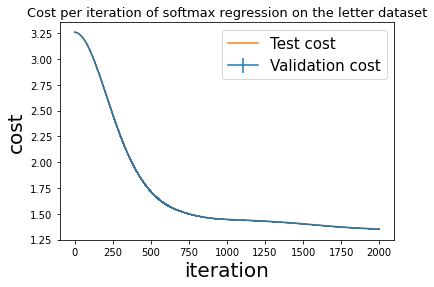

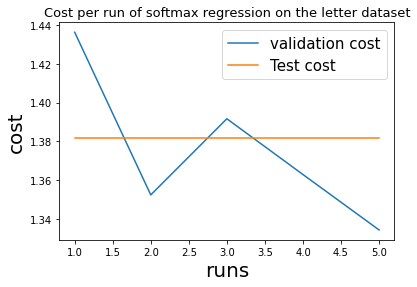

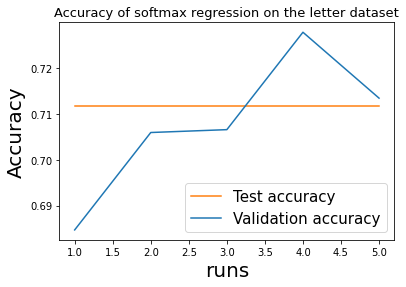

Run time in (s): 494.63689187599994
Run time of test in (s): 122.01213904100018


In [ ]:
optimizer = GradientDescent(learning_rate=1, max_iters=2000,beta=0.999,record_history=True)
num_folds=5
n_rest_letter= letter_instances- n_letter_test
cost_iter=np.zeros((2000,num_folds))
lambdaa=0.001
num_folds = 5
n_rest = digits_instances - n_digits_test
err_valid = np.zeros(5)

start=timer()
acc_l = []
for f, (tr, val) in enumerate(cross_validate(n_rest_letter, num_folds)):
    model = SoftmaxRegression()
    model, cost_iter[:,f] = model.fit(x_letter_train[tr], y_letter_train[tr],optimizer,b=len(x_letter_train[tr])//3,num_classes=letter_classes,lambdaa=lambdaa)
    
    yhl = model.predict(x_letter_train[val])
    acc_l.append(np.sum((y_letter_train[val].argmax(axis=1)==one_hot_y(yhl).argmax(axis=1)))/len(yhl))
    err_valid[f] = cost_fin(y_letter_train[val],yhl ,model.w,lambdaa)
 
print(acc_l)
aver_err_l = (np.sum(acc_l))/num_folds
print("Average Validation Error: ", aver_err_l)

end=timer()

#TEST
start_test=timer()
model = SoftmaxRegression()
model,cost_test = model.fit(x_letter_train, y_letter_train,optimizer,b=len(x_letter_train)//3,num_classes=letter_classes,lambdaa=lambdaa)    
yh_test = model.predict(x_letter_test)
val_err_test=cost_fin(y_letter_test, yh_test ,model.w,lambdaa=lambdaa)
acc_test=np.mean((y_letter_test.argmax(axis=1)==one_hot_y(yh_test).argmax(axis=1)))
end_test=timer()
#end TEST

print('Test accuracy:',acc_test)
mean = np.mean(cost_iter,axis=1)
#plot the accuracy and cost
plt.errorbar(range(2000),mean,np.std(cost_iter,axis=1),label='Validation cost')
plt.plot(range(2000),cost_test,label='Test cost')
plt.title('Cost per iteration of softmax regression on the letter dataset',fontsize=13)
plt.legend(prop={'size': 15})
plt.xlabel('iteration',fontsize=20)
plt.ylabel('cost',fontsize=20)
plt.savefig('cost_per_iter_letter.png',dpi=300)
plt.show()

plt.plot(range(1,6), err_valid, label='validation cost')
plt.plot(range(1,6), [val_err_test]*5, label='Test cost')
plt.legend(prop={'size': 15})
plt.title('Cost per run of softmax regression on the letter dataset',fontsize=13)
plt.xlabel('runs',fontsize=20)
plt.ylabel('cost',fontsize=20)
plt.savefig('cost_per_run_letter.png',dpi=300)
plt.show()

plt.errorbar(range(1,6),acc_l,label='Validation accuracy')
plt.plot(range(1,6), [acc_test]*5, label='Test accuracy')
plt.title('Accuracy of softmax regression on the letter dataset',fontsize=13)
plt.legend(prop={'size': 15})
plt.xlabel('runs',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.savefig('accuracy_letter.png',dpi=300)
plt.show()

print('Run time in (s):',end-start)
print('Run time of test in (s):',end_test-start_test)

# Other models (KNN)

The value of k with the largest average accuracy is 1.
The best accuracy is 0.9749128919860628.


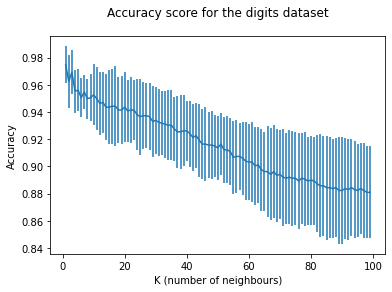

In time: 28.180979773000217
Test accuracy:  0.9526462395543176
Test run time in (s): 0.06638586600001872


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
num_folds = 5
n_rest = digits_instances - n_digits_test
K=100
valid_error=np.zeros((K-1,num_folds))
start=timer()
acc_knn1=[]
avg_acc1=[]
for k in range(1,K):
    acc_knn1=[]
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = KNeighborsRegressor(n_neighbors=k)
        model = model.fit(x_digits_train[tr], y_digits_train[tr])

        yh_knn1 = model.predict(x_digits_train[val])
        acc_knn1.append(accuracy_score(y_digits_train[val],one_hot_y(yh_knn1)))  #(np.mean((y_digits_train[val]== one_hot_y(yh_knn1))))
        valid_error[k-1,f] = accuracy_score(y_digits_train[val],one_hot_y(yh_knn1)) #log_loss(y_digits_train[val], yh_knn1)
    #print(acc_knn1)
    aver_err_knn1 = (np.sum(acc_knn1))/num_folds
    avg_acc1.append(aver_err_knn1)

print("The value of k with the largest average accuracy is {}.".format((np.argmax(avg_acc1)+1)))      
print("The best accuracy is {}.".format(np.amax(avg_acc1)))                              
end=timer()                                    
means = np.mean(valid_error, axis=1)
plt.errorbar(range(1, K), means, np.std(valid_error, axis=1),label='Validation accuracy')
plt.title('Accuracy score for the digits dataset', pad = 20.0)
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy')
plt.savefig('knn_accuracy_digits.png',dpi=300)
plt.show()

print('In time:',end-start)

#Run test with the best K
start_test=timer()
model= KNeighborsRegressor(n_neighbors=1)
model=model.fit(x_digits_train, y_digits_train)
yh_knn1_test = model.predict(x_digits_test)
end_test=timer()
print('Test accuracy: ',accuracy_score(y_digits_test,one_hot_y(yh_knn1_test)))
print('Test run time in (s):',end_test-start_test)

The value of k with the largest average accuracy is 1.
The best accuracy is 0.93725.


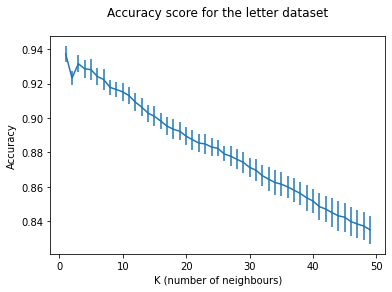

In time: 176.88815458699992
Test accuracy:  0.94525
Test run time in (s): 0.35504173899971647


In [ ]:
num_folds = 5
n_rest = letter_instances - n_letter_test
K=50 #only 50 because it takes more time and the accuracy is only decreasing
valid_error=np.zeros((K-1,num_folds))
start=timer()
acc_knn2=[]
avg_acc2=[]
for k in range(1,K):
    acc_knn2=[]
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = KNeighborsRegressor(n_neighbors=k)
        model = model.fit(x_letter_train[tr], y_letter_train[tr])

        yh_knn2 = model.predict(x_letter_train[val])
        acc_knn2.append(accuracy_score(y_letter_train[val],one_hot_y(yh_knn2)))
        valid_error[k-1,f] = accuracy_score(y_letter_train[val],one_hot_y(yh_knn2))# log_loss(y_letter_train[val], yh_knn2)
    aver_err_knn2 = (np.sum(acc_knn2))/num_folds
    avg_acc2.append(aver_err_knn2)

print("The value of k with the largest average accuracy is {}.".format((np.argmax(avg_acc2)+1)))      
print("The best accuracy is {}.".format(np.amax(avg_acc2)))
end=timer()                                    
means = np.mean(valid_error, axis=1)
plt.errorbar(range(1, K), means, np.std(valid_error, axis=1))
plt.title('Accuracy score for the letter dataset', pad = 20.0)
plt.xlabel('K (number of neighbours)')
plt.ylabel('Accuracy')
plt.savefig('knn_accuracy_letter.png',dpi=300)
plt.show()

print('In time:',end-start)

#Run test with the best K
start_test=timer()
model= KNeighborsRegressor(n_neighbors=1)
model=model.fit(x_letter_train, y_letter_train)
yh_knn2_test = model.predict(x_letter_test)
end_test=timer()
print('Test accuracy: ',accuracy_score(y_letter_test,one_hot_y(yh_knn2_test)))
print('Test run time in (s):',end_test-start_test)